# Toy Example 2 - Parametric prior

In [2]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import elicit as el

from bayesflow.inference_networks import InvertibleNetwork
from elicit.user.generative_models import ToyModel2
from elicit.user.design_matrices import X_toy2

tfd = tfp.distributions

## The Model
### Generative model
\begin{align*}
    (\beta_0, \beta_1, \sigma) &\sim p_\lambda(\cdot) \\
    \mu &= \beta_0 + \beta_1X \\
    y_{pred} &\sim \text{Normal}(\mu, \sigma)
\end{align*}

In [3]:
# create a predictor ranging from 1 to 200 
# standardize predictor
# select the 25th (X0), 50th (X1), and 75th (X2) quantile of the std. predictor for querying the expert
X_toy2(N=200, quantiles=[25,50,75])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.85737586,  0.00866036,  0.85737586], dtype=float32)>

In [4]:
??ToyModel2

Init signature: ToyModel2()
Docstring:      <no docstring>
Source:        
class ToyModel2:
    def __call__(self, ground_truth, prior_samples, design_matrix,
                 **kwargs):
        B = prior_samples.shape[0]
        S = prior_samples.shape[1]

        # design matrix
        X = tf.broadcast_to(design_matrix[None, None,:],
                           (B,S,len(design_matrix)))
        # linear predictor (= mu)
        epred = tf.add(prior_samples[:, :, 0][:,:,None],
                       tf.multiply(prior_samples[:, :, 1][:,:,None], X)
                       )
        # data-generating model
        likelihood = tfd.Normal(
            loc=epred, scale=tf.expand_dims(prior_samples[:, :, -1], -1)
        )
        # prior predictive distribution (=height)
        ypred = likelihood.sample()
        
        # selected observations
        y_X0 = ypred[:,:,0]
        y_X1 = ypred[:,:,1]
        y_X2 = ypred[:,:,2]
        
        return dict(
            likelihood=likeliho

In [5]:
# specify the model
model=el.model(
        obj=ToyModel2,
        design_matrix=X_toy2(N=200, quantiles=[25,50,75])
        )

### Model parameters
+ intercept with normal prior $\beta_0$
+ slope with normal prior $\beta_1$
+ random noise with halfnormal prior $\sigma$

**To be learned hyperparameters**

+ $\lambda$ represent the weights of the deep neural network in the normalizing flow


In [6]:
parameters=[
        el.parameter(name="beta0"),
        el.parameter(name="beta1"),
        el.parameter(name="sigma"),
    ]

## Target quantities and elicitation techniques
**Target quantities**
+ query expert regarding **prior predictions** $y \mid X_{i}$ with $i$ being the 25th, 50th, and 75th quantile.

**Elicitation technique**
+ query each observation using **quantile-based elicitation** using $Q_p(y \mid X)$ for $p=5, 25, 50, 75, 95$

**Importance of elicited statistics in loss**
+ all elicited statistics should have equal importance (weight=1.0)
+ for computing the discrepancy between expert-elicited statistics and model simulations with use the Maximum Mean Discrepancy with Energy kernel

In [7]:
target_quantities=[
        el.target(
            name="y_X0",
            elicitation_method=el.eli_method.quantiles((5, 25, 50, 75, 95)),
            loss=el.MMD_energy,
            loss_weight=1.0
        ),
        el.target(
            name="y_X1",
            elicitation_method=el.eli_method.quantiles((5, 25, 50, 75, 95)),
            loss=el.MMD_energy,
            loss_weight=1.0
        ),
        el.target(
            name="y_X2",
            elicitation_method=el.eli_method.quantiles((5, 25, 50, 75, 95)),
            loss=el.MMD_energy,
            loss_weight=1.0
        ),
        el.target(
            name="correlation",
            elicitation_method=el.eli_method.correlation(),
            loss=el.L2,
            loss_weight=0.1
        )
    ]

## Expert elicitation

+ instead of querying a "real" expert, we define a ground truth (i.e., oracle) and simulate the oracle-elicited statistics

In [8]:
# specify ground truth
ground_truth = {
    "beta0": tfd.Normal(loc=5, scale=1),
    "beta1": tfd.Normal(loc=2, scale=1),
    "sigma": tfd.HalfNormal(scale=10.0),
}

# define oracle
expert=el.expert.simulate(
        ground_truth = ground_truth,
        num_samples = 10_000
    )

## Normalizing Flow

+ we make use of the implementation of NFs in the [`BayesFlow` Python package](https://bayesflow.org/)
+ use affine coupling flows
+ base distribution is a standard normal

In [9]:
normalizing_flow=el.nf(
        inference_network=InvertibleNetwork,
        network_specs=dict(
            num_params=3,
            num_coupling_layers=3,
            coupling_design="affine",
            coupling_settings={
                "dropout": False,
                "dense_args": {
                    "units": 128,
                    "activation": "relu",
                    "kernel_regularizer": None,
                },
                "num_dense": 2,
            },
            permutation="fixed"
        ),
        base_distribution=tfd.MultivariateNormalDiag(
            loc=tf.zeros(3),
            scale_diag=tf.ones(3)
        )
    )

## Training: Learn prior distributions based on expert data

In [10]:
eliobj = el.Elicit(
    model=model,
    parameters=parameters,
    target_quantities=target_quantities,
    expert=expert,
    optimization_settings=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.001,
        clipnorm=1.0
        ),
    training_settings=el.train(
        method="deep_prior",
        name="toy2",
        seed=1,
        epochs=800,
        progress_info=0
    ),
    normalizing_flow=normalizing_flow
)

res_ep, res = eliobj.train(save_file=None)

Training


100%|██████████| 800/800 [11:08<00:00,  1.20it/s]


## Results
### Convergence

[[<matplotlib.lines.Line2D at 0x21d7233be90>],

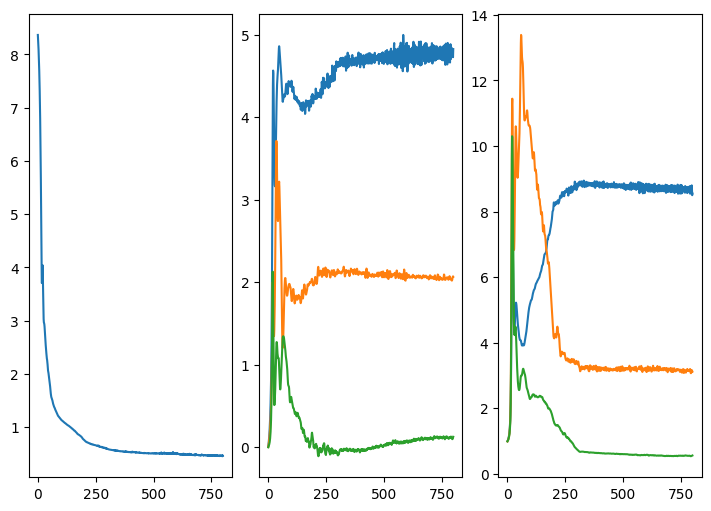

In [11]:
m_ep = tf.stack(res_ep["hyperparameter"]["means"])
s_ep = tf.stack(res_ep["hyperparameter"]["stds"])

_, axs = plt.subplots(1,3, constrained_layout=True, figsize=(7,5), sharex=True)
axs[0].plot(res_ep["loss"])
[axs[1].plot(m_ep[:,i]) for i in range(3)]
[axs[2].plot(s_ep[:,i]) for i in range(3)]

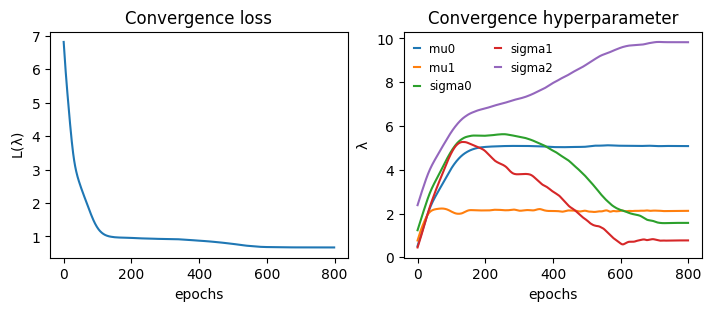

In [98]:
def plot_convergence(res_ep):
    _, axs = plt.subplots(1,2, constrained_layout=True, figsize=(7,3), sharex=True)
    axs[0].plot(res_ep["loss"])
    for k in res_ep["hyperparameter"]:
        axs[1].plot(res_ep["hyperparameter"][k], label=k)
        axs[1].legend(handlelength=0.5, fontsize="small", frameon=False, ncol=2)
    axs[0].set_title("Convergence loss")
    axs[1].set_title("Convergence hyperparameter")
    axs[0].set_ylabel(r"$\mathcal{L}(\lambda)$")
    axs[1].set_ylabel(r"$\lambda$")
    [axs[i].set_xlabel("epochs") for i in range(2)]
    plt.show()

plot_convergence(res_ep)

### Expert expectations

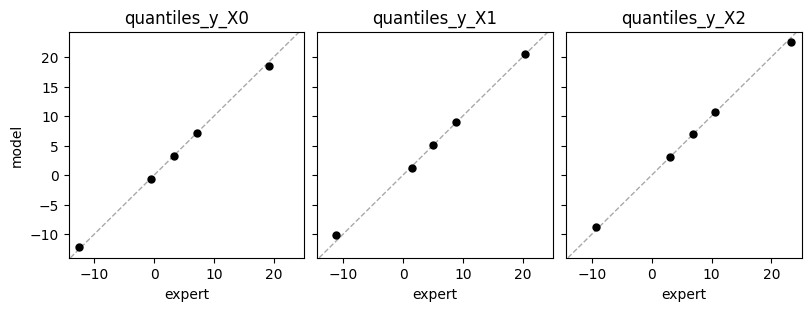

In [99]:
def plot_expert_data(res):
    _, axs = plt.subplots(1,3, constrained_layout=True, figsize=(8,3), sharex=True, sharey=True)
    for j,key in enumerate(res["expert_elicited_statistics"]):
        axs[j].axline((0,0), slope=1, color="darkgrey", linestyle="dashed", lw=1)
        axs[j].plot(res["expert_elicited_statistics"][key][0,:], 
                     tf.reduce_mean(res["elicited_statistics"][key],0), "o", ms=5, color="black")
        axs[j].set_title(key)
        axs[j].set_xlabel("expert")
    axs[0].set_ylabel("model")
    plt.show()

plot_expert_data(res)

### Learned priors

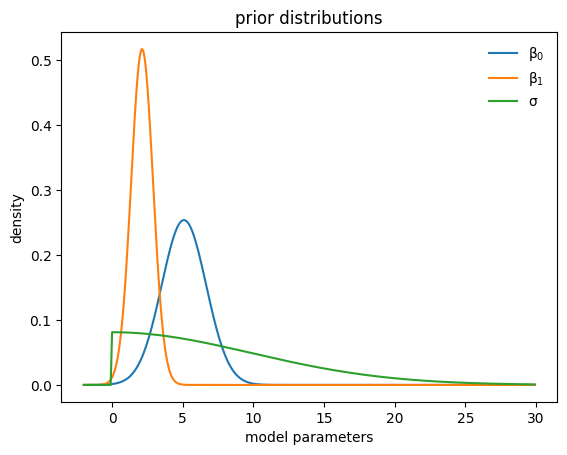

In [100]:
def plot_priors(res_ep, shared=False):
    mu0=tf.reduce_mean(res_ep["hyperparameter"]["mu0"][-30:])
    if shared:
        sigma0=tf.reduce_mean(res_ep["hyperparameter"]["sigma1"][-30:])
    else:
        sigma0=tf.reduce_mean(res_ep["hyperparameter"]["sigma0"][-30:])
    mu1=tf.reduce_mean(res_ep["hyperparameter"]["mu1"][-30:])
    sigma1=tf.reduce_mean(res_ep["hyperparameter"]["sigma1"][-30:])
    sigma2=tf.reduce_mean(res_ep["hyperparameter"]["sigma2"][-30:])
    
    x=tf.range(-2., 30., 0.1)
    y0=tfd.Normal(mu0,sigma0).prob(x)
    y1=tfd.Normal(mu1,sigma1).prob(x)
    y2=tfd.HalfNormal(sigma2).prob(x)
    
    plt.plot(x,y0, label=r"$\beta_0$")
    plt.plot(x,y1, label=r"$\beta_1$")
    plt.plot(x,y2, label=r"$\sigma$")
    plt.legend(frameon=False)
    plt.ylabel("density")
    plt.xlabel("model parameters")
    plt.title("prior distributions")
    plt.show()

plot_priors(res_ep)

## Add-on: Shared parameters

In [10]:
parameters_shared=[
        el.parameter(
            name="beta0",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu0"),
                scale=el.hyper("sigma1", lower=0, shared=True)
                )
        ),
        el.parameter(
            name="beta1",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu1"),
                scale=el.hyper("sigma1", lower=0, shared=True)
                )
        ),
        el.parameter(
            name="sigma",
            family=tfd.HalfNormal,
            hyperparams=dict(
                scale=el.hyper("sigma2", lower=0)
                )
        ),
    ]

eliobj2 = el.Elicit(
    model=model,
    parameters=parameters_shared,
    target_quantities=target_quantities,
    expert=expert,
    optimization_settings=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.05,
        clipnorm=1.0
        ),
    training_settings=el.train(
        method="parametric_prior",
        name="toy2",
        seed=1,
        epochs=800,
        progress_info=0
    ),
    initialization_settings=el.initializer(
        method="random",
        loss_quantile=0,
        iterations=10,
        specs=el.init_specs(
            radius=1.,
            mean=0.
            )
        )
)

res_ep2, res2 = eliobj2.train(save_file=None)

Initialization


100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


 
Training


100%|██████████| 800/800 [04:06<00:00,  3.24it/s]


### Results
#### Convergence

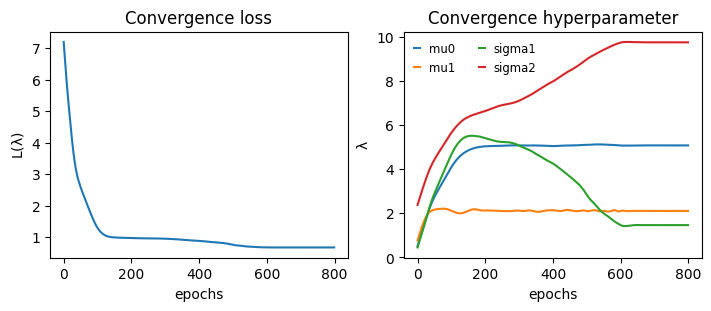

In [101]:
plot_convergence(res_ep2)

#### Expert expectations

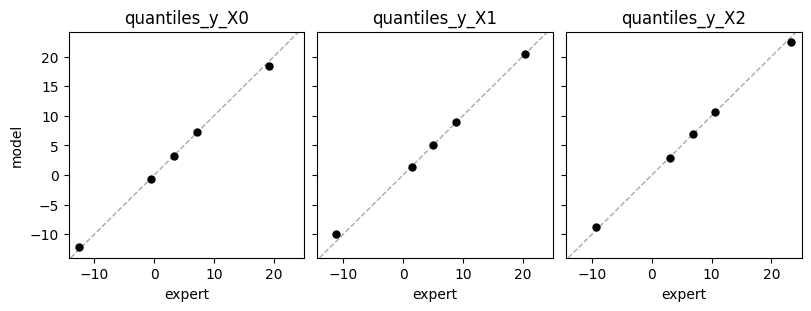

In [102]:
plot_expert_data(res2)

#### Learned priors

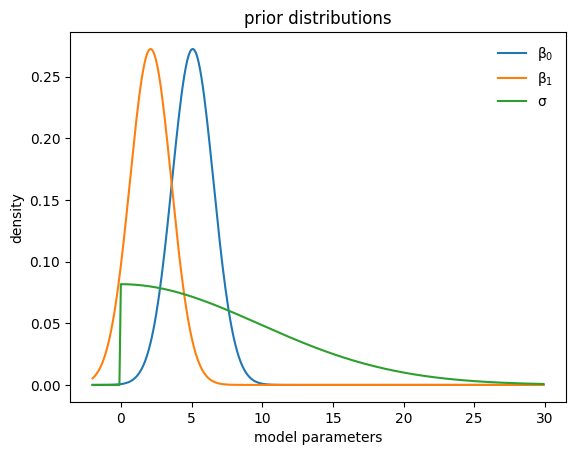

In [103]:
plot_priors(res_ep2, shared=True)

## Add-on: Use expert data as input

In [95]:
expert_dat = {
    "quantiles_y_X0": [-12.5, -0.6, 3.3, 7.1, 19.1],
    "quantiles_y_X1": [-11.2, 1.5, 5.0, 8.8, 20.4],
    "quantiles_y_X2": [-9.3, 3.1, 6.8, 10.5, 23.3]
}

# define expert data
expert=el.expert.data(dat = expert_dat)

eliobj3 = el.Elicit(
    model=model,
    parameters=parameters,
    target_quantities=target_quantities,
    expert=expert,
    optimization_settings=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.05,
        clipnorm=1.0
        ),
    training_settings=el.train(
        method="parametric_prior",
        name="toy2",
        seed=1,
        epochs=1000,
        progress_info=0
    ),
    initialization_settings=el.initializer(
        method="random",
        loss_quantile=0,
        iterations=10,
        specs=el.init_specs(
            radius=1.,
            mean=0.
            )
        )
)

res_ep3, res3 = eliobj3.train(save_file=None)

Initialization


100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


 
Training


100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]


### Results
#### Convergence

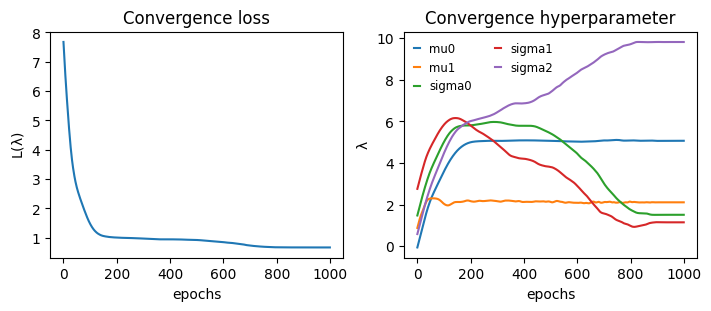

In [104]:
plot_convergence(res_ep3)

#### Expert expectations

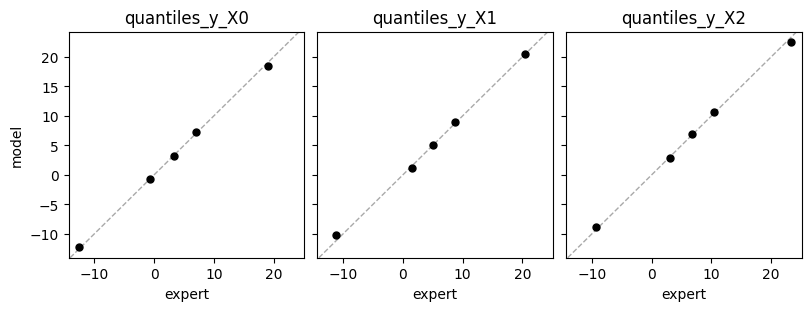

In [105]:
plot_expert_data(res3)

#### Learned priors

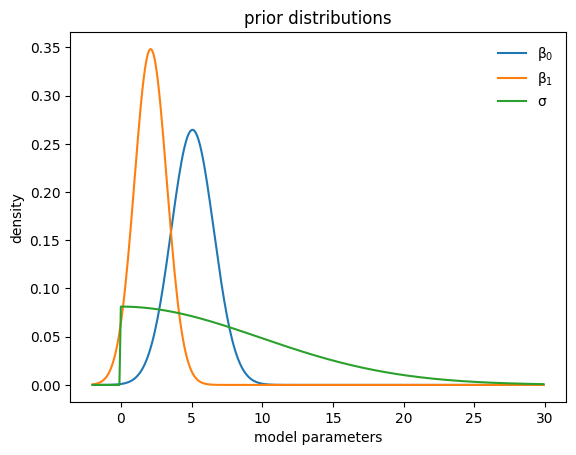

In [106]:
plot_priors(res_ep3)